# Introduction

This lab will explore the Steiner tree problem, examining heuristics as well as optimal solution methods.

First, import required packages.

In [225]:
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import treeopt
import numpy as np
from scipy.spatial import Delaunay

from networkx.algorithms import approximation

import gurobipy as gp
from gurobipy import GRB

# Generating a Random Graph

Next, set some parameters related to how we will construct the graph.

In [226]:
num_vertices = 15
num_terminals = 5
distance_max = 0.55
np.random.seed(41)

To ensure that the solutions to the Steiner Tree Problem are not trivial, I manually added edges and manually changed some edge weights.

In [227]:
edges_to_add = [(1,9)]
weights_to_change = {(3,10) : 7, (0,1) : 6, (9,10) : 7, (1,9) : 12}

Next, we randomly generate points and use the Delaunay triangulation to ensure that the graph is *planar* (i.e., the edges to not cross over each other).

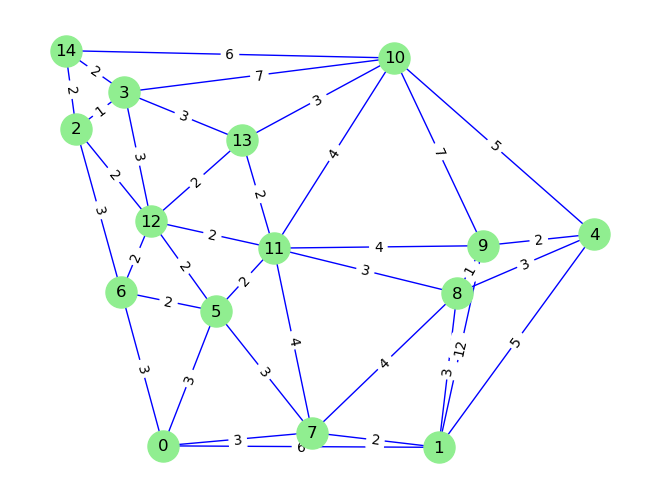

In [228]:
points = np.random.rand(num_vertices, 2)

# Compute the Delaunay triangulation of these points
tri = Delaunay(points)

G = nx.Graph()
G.add_nodes_from(range(num_vertices))

for i in range(num_vertices):
    G.nodes[i]['pos'] = points[i]

# For every triangle (simplex), add edges between its vertices
for simplex in tri.simplices:
    for i in range(len(simplex)):
        for j in range(i + 1, len(simplex)):
            u, v = simplex[i], simplex[j]
            distance = 1 + 10*np.linalg.norm(points[u] - points[v])
            G.add_edge(u, v, weight=int(distance))


# Remove some edges that have a distance longer than distance_max
for edge in list(G.edges()):
    distance = np.linalg.norm(points[edge[0]] - points[edge[1]])
    if distance > distance_max:
        G.remove_edge(*edge)

for (i,j) in edges_to_add:
    distance = 1 + 10*np.linalg.norm(points[i] - points[j])
    G.add_edge(i,j, weight=int(distance))

for edge in weights_to_change:
    if G.has_edge(*edge):
        G[edge[0]][edge[1]]['weight'] = weights_to_change[edge]
        
pos = {i: G.nodes[i]['pos'] for i in G.nodes()}

nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color='blue', node_size=500)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

This code writes this graph as a LaTeX ``tikzpicture``.

In [229]:
treeopt.graph_to_latex(G, scale = 10, edge_labels = edge_labels, tikz_file_name = "graph15.tex")

# Minimum Spanning Tree

In [230]:
# Find the minimum spanning tree using an algorithm built in to networkx.
mst = nx.minimum_spanning_tree(G)

total_weight = sum(G[u][v]['weight'] for u, v in mst.edges())
print("Total weight of the minimum spanning tree:", total_weight)

Total weight of the minimum spanning tree: 30


Then we display the MST solution on the graph.

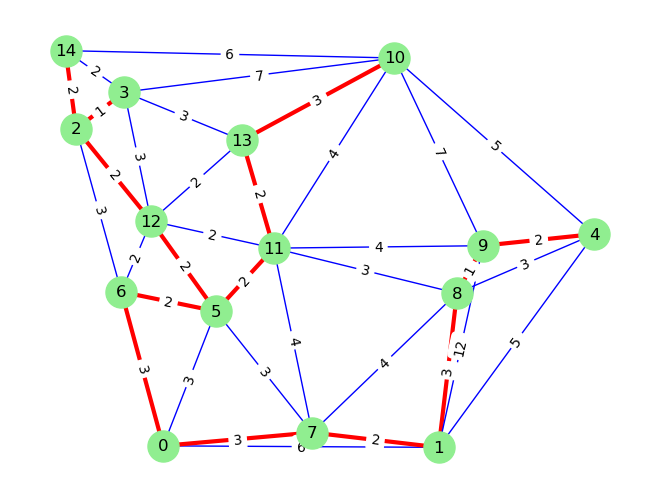

In [231]:
# Set edge attributes for MST edges
for u, v in G.edges():
    if (u,v) in mst.edges():
        G[u][v]['color'] = 'red'
        G[u][v]['width'] = 3.0
    else:
        G[u][v]['color'] = 'blue'
        G[u][v]['width'] = 1.0

edge_colors = ['red' if G[u][v].get('color') == 'red' else 'blue' for u, v in G.edges()]
widths = [G[u][v]['width'] for u, v in G.edges()]

# Draw the graph with MST edges in red and thicker
nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color=edge_colors, width = widths, node_size=500)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

Again, the following code writes this graph as a LaTeX ``tikzpicture``.

In [232]:
edge_opts = {e: treeopt.get_edge_style(e, mst.edges()) for e in G.edges}

treeopt.graph_to_latex(G, scale = 10, edge_labels = edge_labels, edge_opts=edge_opts,
                       tikz_file_name = "mst15.tex")

# Minimum Steiner Tree Problem

Next we will turn to the Minimum Steiner Tree Problem. The following code randomly selects some of the vertices to be terminals. Thus, the remaining vertices are *Steiner vertices*.

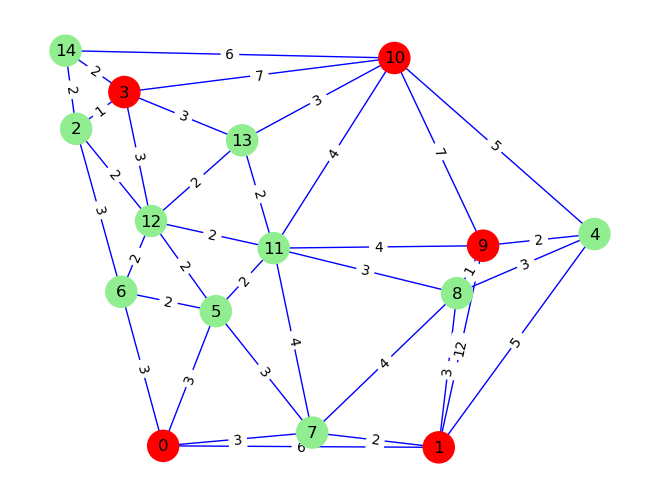

In [233]:
# sample a set of 5 terminal vertices
terminals = np.random.choice(num_vertices, size=num_terminals, replace=False)

# Set the color of terminal vertices to a different color
node_colors = ['lightgreen' if i not in terminals else 'red' for i in range(num_vertices)]

# Draw the graph with terminal vertices labeled in red
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='blue', node_size=500)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

Again, we export the graph to LaTeX.

In [234]:
def get_node_style(i):
    if i in terminals:
        return "terminal_style"
    else:
        return "node_style"

node_opts = {i: get_node_style(i) for i in G.nodes()}
treeopt.graph_to_latex(G, scale = 10, edge_labels = edge_labels, node_opts = node_opts, 
                       tikz_file_name = "terminals15.tex")

# Heuristic Solutions

Because the Minimum Steiner Tree problem is NP-hard, we next examine several heuristics for solving it.

## Heuristic from Kuo et al. (1981)

The following code uses the heuristic from Kuo et al. (1981) to obtain a Steiner tree solution.

In [235]:
steiner_tree = approximation.steiner_tree(G, list(terminals), method = "kou");
total_weight = sum(G[u][v]['weight'] for u, v in steiner_tree.edges())
print(f'Total weight of the Steiner tree: {total_weight}')

Total weight of the Steiner tree: 22


Here we display the solution on the graph.

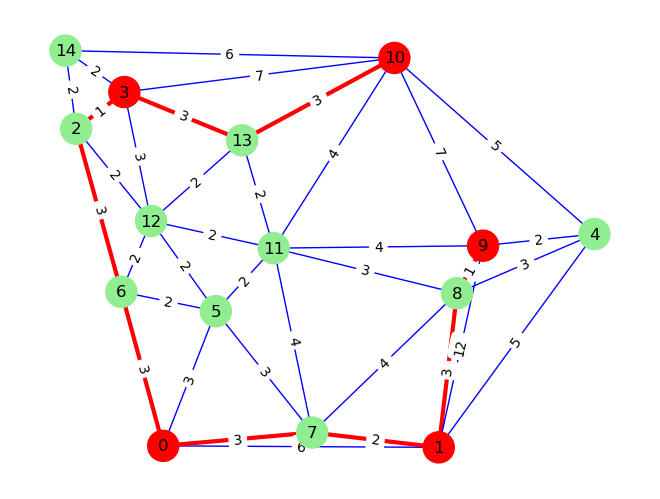

In [236]:
treeopt.display_steiner_solution(G, steiner_tree, node_colors)

And we then write the graph as a ``tikzpicture``.

In [237]:
edge_opts = {e: treeopt.get_edge_style(e, steiner_tree.edges()) for e in G.edges}
node_opts = {i: get_node_style(i) for i in G.nodes()}

treeopt.graph_to_latex(G, scale = 10, edge_labels = edge_labels, node_opts = node_opts, 
                       edge_opts = edge_opts, tikz_file_name = "steiner-kou-15.tex")

# Heuristic from Mehlhorn et al. (1986)

The following code uses the heuristic from Mehlhorn et al. (1981) to obtain a Steiner tree solution.

In [238]:
steiner_tree = approximation.steiner_tree(G, list(terminals), method = "mehlhorn");
total_weight = sum(G[u][v]['weight'] for u, v in steiner_tree.edges())
print(f'Total weight of the Steiner tree: {total_weight}')

Total weight of the Steiner tree: 23


Here we display the solution on the graph and export as ``tikzpicture``.

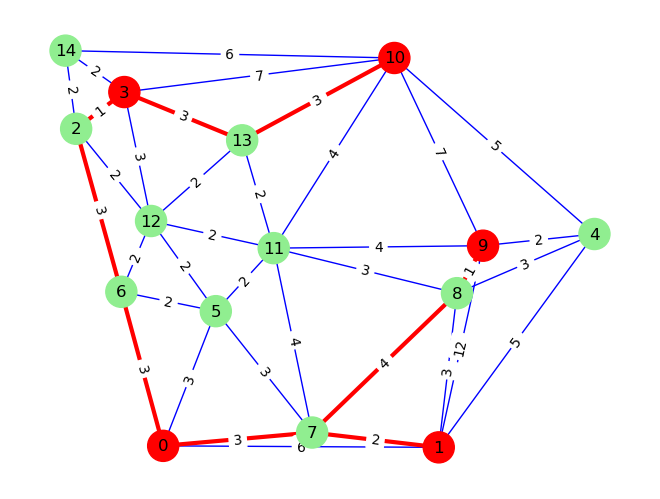

In [239]:
treeopt.display_steiner_solution(G, steiner_tree, node_colors)

edge_opts = {e: treeopt.get_edge_style(e, steiner_tree.edges()) for e in G.edges}
node_opts = {i: get_node_style(i) for i in G.nodes()}

treeopt.graph_to_latex(G, scale = 10, edge_labels = edge_labels, node_opts = node_opts, 
                       edge_opts = edge_opts, tikz_file_name = "steiner-mehlhorn-15.tex")

# Exact Methods



## Integer Programming

Objective value: 20.0


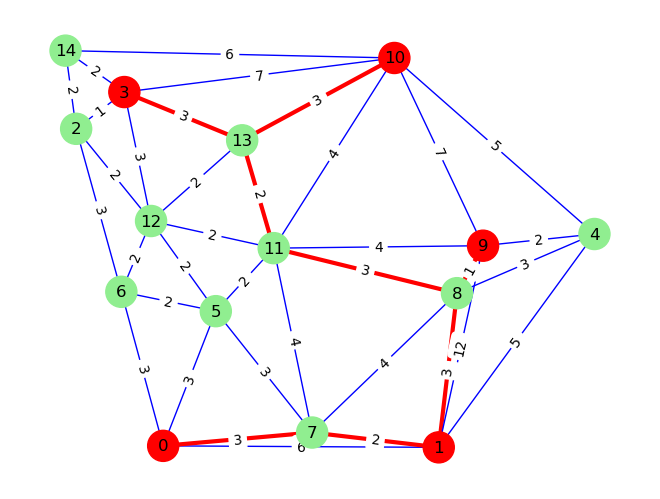

In [240]:
model = gp.Model("Steiner_Tree")
diGraph = treeopt.get_digraph(G)
arcs = diGraph.edges()

x = model.addVars(G.edges(), vtype=GRB.BINARY, name="x")

y = model.addVars(arcs, terminals[1:], vtype=GRB.CONTINUOUS, name="y")

model.setObjective(gp.quicksum(G[u][v]['weight']*x[u,v] for u,v in G.edges()), GRB.MINIMIZE)

root = terminals[0]

def get_net_flow_rhs(i : int, k : int, root : int):
    if i == root:
        return 1
    elif i == k:
        return -1
    else:
        return 0

# flow balance constraints
for k in terminals[1:]:
    for i in G.nodes():
        outflow = gp.quicksum(y[i,j,k] for i,j in diGraph.out_edges(i))
        inflow = gp.quicksum(y[j,i,k] for j,i in diGraph.in_edges(i))
        model.addConstr(outflow - inflow == get_net_flow_rhs(i,k,root), name=f"flow_balance_{i}_{k}")

# flow activation constraints
model.addConstrs(y[i,j,k] <= x[i,j] for (i,j) in G.edges() for k in terminals[1:])
model.addConstrs(y[j,i,k] <= x[i,j] for (i,j) in G.edges() for k in terminals[1:])

model.setParam('OutputFlag', 0)
model.optimize()

print("Objective value:", model.ObjVal)

steiner_tree_edges = [(u, v) for u, v in G.edges() if x[u, v].x > 0.5]

for u, v in G.edges():
    if (u, v) in steiner_tree_edges:
        G[u][v]['color'] = 'red'
        G[u][v]['width'] = 3.0
    else:
        G[u][v]['color'] = 'blue'
        G[u][v]['width'] = 1.0

edge_colors = ['red' if G[u][v].get('color') == 'red' else 'blue' for u, v in G.edges()]
widths = [G[u][v]['width'] for u, v in G.edges()]

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, width=widths, node_size=500)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

edge_opts = {e: treeopt.get_edge_style(e, steiner_tree_edges) for e in G.edges}
node_opts = {i: get_node_style(i) for i in G.nodes()}

treeopt.graph_to_latex(G, scale = 10, edge_labels = edge_labels, node_opts = node_opts, 
                       edge_opts = edge_opts, tikz_file_name = "steiner-opt-15.tex")